In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, precision_score, balanced_accuracy_score

from sklearn.datasets import make_moons
from scipy.cluster.hierarchy import dendrogram

# new import statements
from sklearn.cluster import KMeans, AgglomerativeClustering

# Unsupervised Machine Learning: Clustering

- In classification (supervised), we try to find boundaries/rules to separate points according to pre-determined labels.
- In clustering, the algorithm chooses the labels.  Goal is to choose labels so that similar rows get labeled the same.

### K-Means Clustering

- K: number of clusters:
    - 3-Means => 3 clusters
    - 4-Means => 4 clusters, and so on
- Means: we will find centroids (aka means aka averages) to create clusters

#### Iterative algorithm for K-Means

In [2]:
# Generate random data
x, y = datasets.make_blobs(n_samples=100, centers=3, cluster_std=1.2, random_state=3)
df = pd.DataFrame(x, columns=["x0", "x1"])
df.head()

,x0,x1
0,8.370099,7.747045
1,-2.701740,0.395336
2,-3.204128,-0.407438
3,-3.132762,-1.335692
4,7.152737,6.069995


In [3]:
km_cluster = KMeans(3)

# `fit`: find good centroids
km_cluster.fit(df)

# coordinates of cluster centers
print(km_cluster.cluster_centers_)

# `transform`: give me the distances from each point to each centroid
km_cluster.transform(df)

# `predict`: give me the chosen group labels
km_cluster.predict(df)

[[ 7.69751168  7.9241129 ]
 [-4.41347291  0.43410278]
 [ 0.85985598  3.98556415]]


array([0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 2,
       1, 2, 1, 0, 0, 2, 1, 0, 2, 2, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2,
       1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 2, 2, 2, 1, 2, 2, 1, 2,
       0, 1, 2, 1, 1, 0, 2, 1, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 0, 2, 1, 0,
       2, 0, 2, 0, 0, 1, 0, 1, 1, 2, 0, 0], dtype=int32)

### How many clusters do we need?

- metric: `<km object>.inertia_`: sum of squared distances of samples to their closest cluster center

In [4]:
km_cluster.inertia_

260.7196850565891

**Observation**: we want "inertia" to be as small as possible.

### Elbow plot to determine `n_clusters`

In [5]:
s = pd.Series(dtype=float)

for num_clusters in range(1, 11):
    km = KMeans(num_clusters)
    km.fit(df)
    s.at[num_clusters] = km.inertia_

s

1     3621.095890
2      927.007644
3      260.719685
4      211.730031
5      180.638396
6      153.314675
7      129.947745
8      110.003994
9       93.498871
10      82.546640
dtype: float64

Text(0.5, 0, 'Number of clusters')

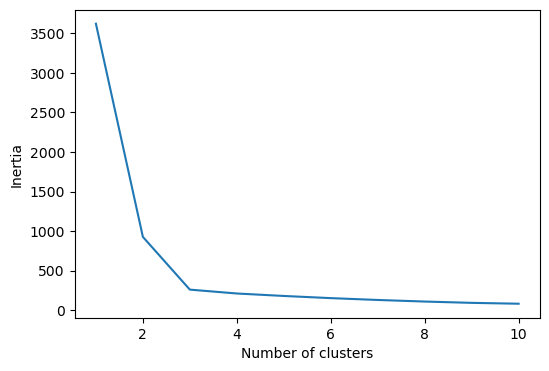

In [6]:
ax = s.plot.line(figsize=(6, 4))
ax.set_ylabel("Inertia")
ax.set_xlabel("Number of clusters")

**Observation**: there is an "elbow" around `n_clusters`=3.

#### Will we always have a clear "elbow"?

- Let's generate uniform random data

Text(0.5, 0, 'Number of clusters')

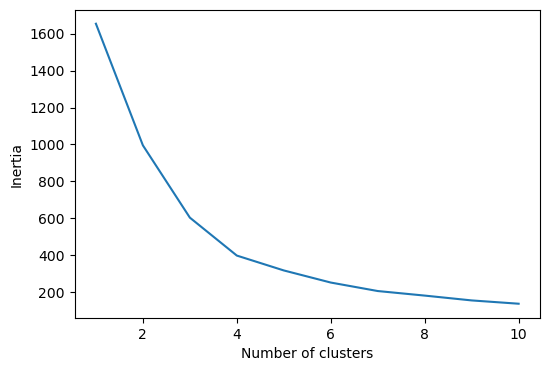

In [7]:
df2 = pd.DataFrame(np.random.uniform(0, 10, (100, 2)))

s = pd.Series(dtype=float)

for num_clusters in range(1, 11):
    km = KMeans(num_clusters)
    km.fit(df2)
    s.at[num_clusters] = km.inertia_

ax = s.plot.line(figsize=(6, 4))
ax.set_ylabel("Inertia")
ax.set_xlabel("Number of clusters")

### K-Means use cases:

1. estimator
2. transformer:
    - sometimes we'll use an unsupervised learning technique (like k-means) to pre-process data, creating better inputs for a supervised learning technique (like logistic regression)

In [8]:
def make_data():
    x, y = datasets.make_blobs(n_samples=250, centers=5, random_state=5)
    xcols = ["x0", "x1"]
    df1 = pd.DataFrame(x, columns=xcols)
    df1["y"] = y > 0

    df2 = pd.DataFrame(np.random.uniform(-10, 10, size=(250, 2)), columns=["x0", "x1"])
    df2["y"] = False

    return pd.concat((df1, df2))

train, test = train_test_split(make_data())

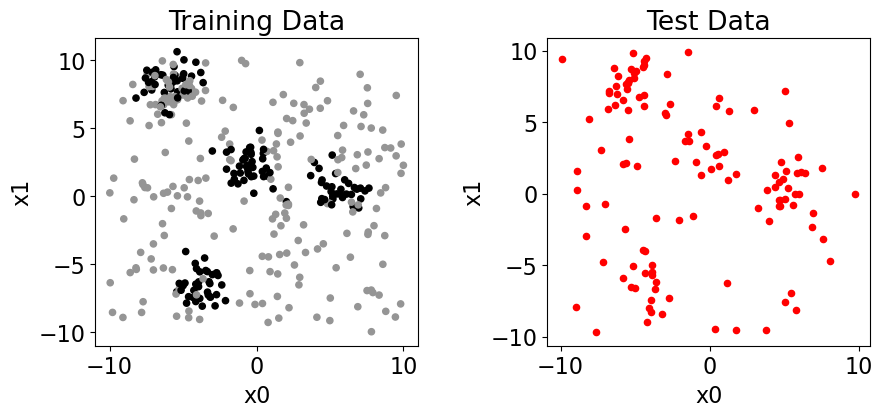

In [9]:
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
train.plot.scatter(x="x0", y="x1", c=train["y"], vmin=-1, ax=ax[0])
test.plot.scatter(x="x0", y="x1", c="red", ax=ax[1])
ax[0].set_title("Training Data")
ax[1].set_title("Test Data")
plt.subplots_adjust(wspace=0.4)

#### Objective: use `LogisticRegression` to classify points as "black" or "gray".

In [10]:
model = Pipeline([
    ("km", KMeans(10)),
    ("lr", LogisticRegression()),
])
model.fit(train[["x0", "x1"]], train["y"])
model.score(test[["x0", "x1"]], test["y"])

/Users/msyamkumar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8

In [11]:
model = Pipeline([
    ("km", KMeans(10)),
    ("std", StandardScaler()),
    ("lr", LogisticRegression()),
])
model.fit(train[["x0", "x1"]], train["y"])
model.score(test[["x0", "x1"]], test["y"])

0.808

### `StandardScaler` with `KMeans`

Recall that `StandardScaler` should always be applied after applying `PolynomialFeatures` (from last lecture).

<AxesSubplot:xlabel='0', ylabel='1'>

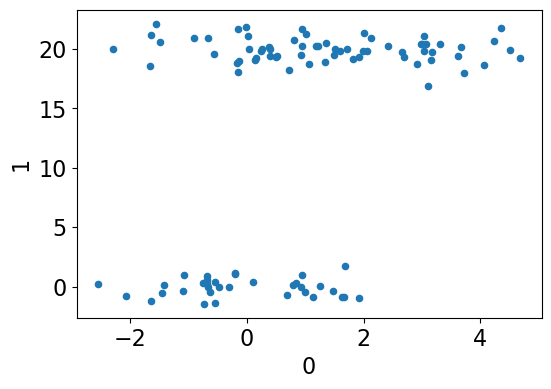

In [12]:
x = datasets.make_blobs(centers=np.array([(0, 0), (0, 20), (3, 20)]))[0]
df = pd.DataFrame(x)
df.plot.scatter(x=0, y=1, figsize=(6, 4))

In [13]:
km_c = KMeans(2)
km_c.fit(df)
km_c.predict(df)

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

#### `fit_predict(...)` is a shortcut for `fit` and `predict` method invocations.

In [14]:
KMeans(2).fit_predict(df)

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

<AxesSubplot:xlabel='0', ylabel='1'>

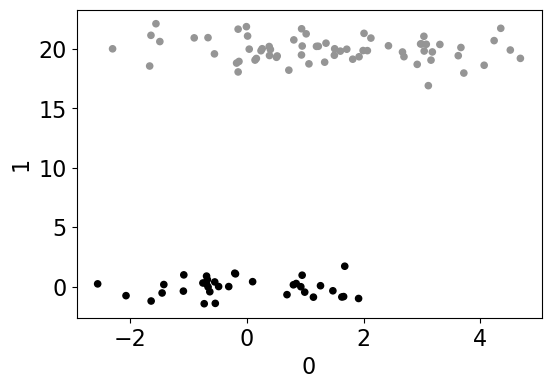

In [15]:
# -1 => white, 0 => gray, 1 => black
df.plot.scatter(x=0, y=1, figsize=(6, 4), c=KMeans(2).fit_predict(df), vmin=-1, vmax=1)

**Observation**: scale for columns are intentionally not specified.

In [16]:
df

,0,1
0,0.159947,19.205974
1,-0.905424,20.942323
2,1.190662,20.227677
3,1.497398,19.477952
4,3.108567,16.917854
...,...,...
95,0.009770,21.097265
96,-1.643981,-1.220612
97,-1.494621,20.632358
98,-0.138085,18.958483


Let's make a copy of the data. Assuming initial data for both columns is in "km", let's convert one column (`0`) into "meters". 

In [17]:
df2 = df.copy()
df2[0] *= 1000 # km => m
df2.head()

,0,1
0,159.947014,19.205974
1,-905.423918,20.942323
2,1190.661739,20.227677
3,1497.397880,19.477952
4,3108.567261,16.917854


<AxesSubplot:xlabel='0', ylabel='1'>

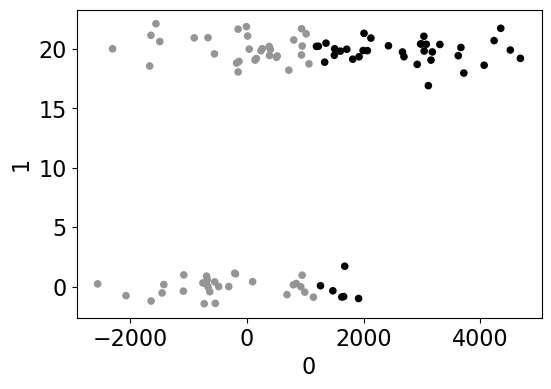

In [18]:
df2.plot.scatter(x=0, y=1, figsize=(6,4), c=KMeans(2).fit_predict(df2), vmin=-1, vmax=1)

**Observations**:
- One would expect to see the same clusters, but that is not happening here. Why?
    - x-axis difference is too high when compared to the y-axis difference
    - That is, KMeans doesn't get that x-axis has scaled data, whereas y-axis doesn't have scaled data
- This is not too far off from realistic datasets. 
    - That is, real-world dataset columns might have difference units. 
    - For example, one column might be representing temperature data where as another might be representing distance.

#### Conclusion: `StandardScaler` should be applied before `KMeans`

<AxesSubplot:xlabel='0', ylabel='1'>

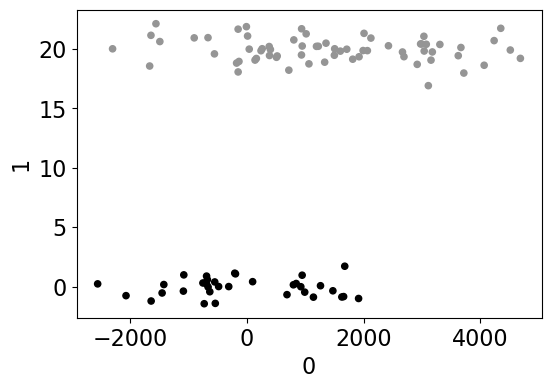

In [19]:
model = Pipeline([
    ("std", StandardScaler()),
    ("km", KMeans(2)),
])

df2.plot.scatter(x=0, y=1, figsize=(6, 4), c=model.fit_predict(df2), vmin=-1, vmax=1)

### Wisconsin counties example

In [20]:
df = gpd.read_file("counties.geojson")
df.head()

,NAME,POP100,AREALAND,HU100,developed,forest,pasture,crops,geometry
0,Racine County,195408,861533739,82164,0.230906,0.100167,0.072588,0.482126,"POLYGON ((645313.81834 2212738.58489, 645456.3..."
1,Clark County,34690,3133378070,15076,0.046476,0.326691,0.022979,0.444642,"POLYGON ((431909.29098 2393751.35940, 433872.5..."
2,Wood County,74749,2054044751,34088,0.080285,0.226244,0.023411,0.320990,"POLYGON ((498653.94690 2388370.84202, 498647.3..."
3,Rusk County,14755,2366092584,8883,0.035567,0.473937,0.049572,0.138357,"POLYGON ((397166.23292 2498521.78567, 397167.7..."
4,Ozaukee County,86395,603514413,36267,0.222642,0.088609,0.127867,0.389109,"POLYGON ((654796.85595 2272096.94081, 654799.8..."


#### If we want to use "POP100", "AREALAND", "developed", "forest", "pasture", "crops" for clustering, what transformer should we use? 

- StandardScaler.

### Goal here: cluster counties based on similar land usage.

<AxesSubplot:>

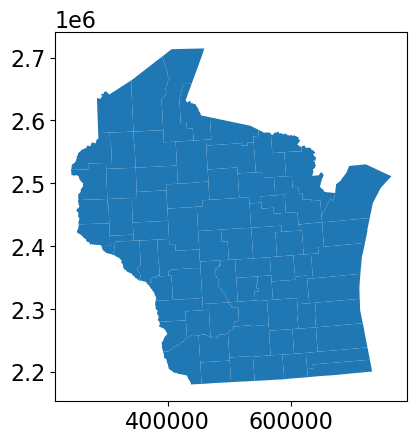

In [21]:
df.plot()

<AxesSubplot:>

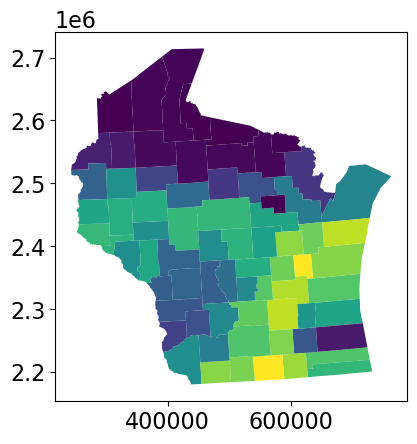

In [22]:
df.plot(column="crops")

<AxesSubplot:>

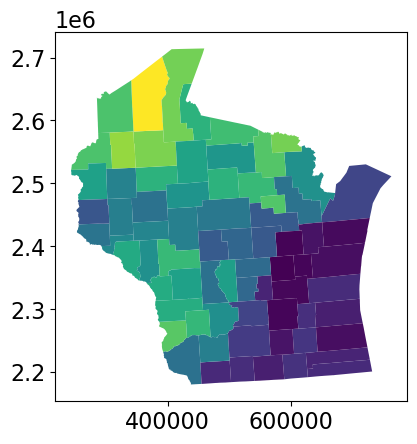

In [23]:
df.plot(column="forest")

### KMeans

1.29112426749881
[1 3 3 0 1 3 1 2 0 3 1 1 1 0 3 2 3 3 0 0 3 0 3 1 0 3 3 3 0 1 1 1 0 3 3 3 1
 3 0 1 1 3 3 1 0 0 0 1 3 3 3 1 0 0 0 1 3 3 1 1 0 1 0 0 1 3 0 0 0 0 0 3]


<AxesSubplot:>

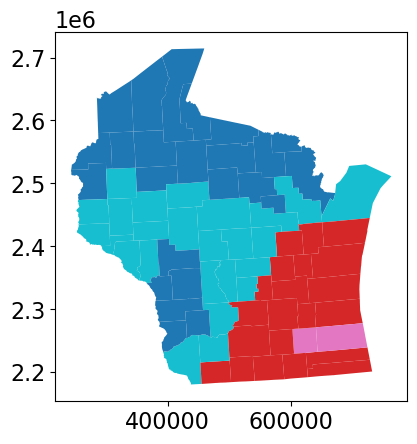

In [24]:
xcols = ["developed", "forest", "pasture", "crops"]

# instantiate
km_c = KMeans(4)
# fit
km_c.fit(df[xcols])
# predict
clusters = km_c.predict(df[xcols])

print(km_c.inertia_)
print(clusters)

df.plot(column=clusters, cmap="tab10")

**Observation**: cluster number can be random. That is, if you re-run the above cell twice, you will get different number for each cluster.

### Agglomerative clustering

- import statement
```python
from sklearn.cluster import AgglomerativeClustering
```

In [25]:
xcols = ["developed", "forest", "pasture", "crops"]

# instantiate
km_c = AgglomerativeClustering(4)
# fit
km_c.fit(df[xcols])
# predict
clusters = km_c.predict(df[xcols])

print(km_c.inertia_)
print(clusters)

df.plot(column=clusters, cmap="tab10")

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

In [26]:
xcols = ["developed", "forest", "pasture", "crops"]

# instantiate
km_c = AgglomerativeClustering(4)
# fit
km_c.fit(df[xcols])
# predict
clusters = km_c.predict(df[xcols])

# print(km_c.inertia_)
print(clusters)

df.plot(column=clusters, cmap="tab10")

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

**Observations**: 
- no centroids => no inertia => no elbow plots (how do we pick cluster count?):
    - AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'
- no `predict` method, but there is `fit_predict`:
    - AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'
    - why?
        - because each point could lead to a completely different tree
        - remember unlike KMeans (which is top-down), AgglomerativeClustering is bottom-up

[2 1 1 0 2 0 2 3 0 1 2 2 2 0 1 3 1 1 0 0 1 0 0 2 0 1 1 1 0 2 2 2 0 1 1 1 2
 1 0 2 2 1 1 2 0 0 0 2 1 1 1 2 0 0 0 2 1 1 2 2 0 2 0 0 2 0 0 0 0 0 0 1]


<AxesSubplot:>

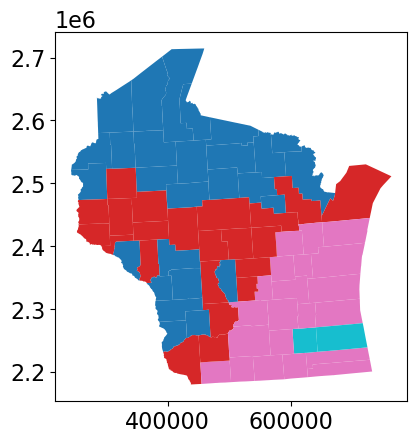

In [27]:
xcols = ["developed", "forest", "pasture", "crops"]

# instantiate
km_c = AgglomerativeClustering(4)
# fit_predict
clusters = km_c.fit_predict(df[xcols])

# print(km_c.inertia_)
print(clusters)

df.plot(column=clusters, cmap="tab10")